In [22]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import regularizers


import tensorflow as tf
from tensorflow.keras import layers
import chess
import numpy as np


In [23]:
def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    turn_part = parts[1]
    castling_part = parts[2]

    # Convert the board position to a binary matrix
    board = chess.Board(fen)
    binary_board = np.zeros((8, 8, 18), dtype=np.float32)
    pieces = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5,
              'P': 6, 'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11}
    
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            binary_board[i // 8, i % 8, pieces[str(piece)]] = 1.0

    # Add the turn to the binary matrix
    if turn_part == 'w':
        binary_board[..., 12] = 1.0
    else:
        binary_board[..., 13] = 1.0

    # Add the castling rights to the binary matrix
    if 'K' in castling_part:
        binary_board[..., 14] = 1.0
    if 'Q' in castling_part:
        binary_board[..., 15] = 1.0
    if 'k' in castling_part:
        binary_board[..., 16] = 1.0
    if 'q' in castling_part:
        binary_board[..., 17] = 1.0

    return binary_board


In [24]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 18)),  # Increase the number of filters
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Dropout layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Increase the number of filters
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Dropout layer
    # layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # New convolutional layer
    # layers.MaxPooling2D((2, 2)),
    # Dropout(0.5),  # Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Increase the number of neurons
    Dropout(0.5),  # Dropout layer
    layers.Dense(64, activation='relu'),  # Increase the number of neurons
    Dropout(0.5),  # Dropout layer
    layers.Dense(1)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          10432     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 4, 4, 64)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 2, 2, 128)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 2, 2, 128)        

In [26]:
with open(r'processed_data\output_1.txt', 'r') as f:
    lines = f.readlines()

fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [float(line.split()[-1])/100 for line in lines]


boards = np.array([fen_to_board(fen) for fen in fens])
ratings = np.array(ratings)

In [27]:
train_size = int(len(boards) * 0.7)
val_size = int(len(boards) * 0.15)

x_train, y_train = boards[:train_size], ratings[:train_size]
x_val, y_val = boards[train_size:train_size+val_size], ratings[train_size:train_size+val_size]
x_test, y_test = boards[train_size+val_size:], ratings[train_size+val_size:]


In [28]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=10)

Epoch 1/10


31574/31574 [==============================] - 335s 10ms/step - loss: 0.0414 - accuracy: 0.0413 - val_loss: 0.0410 - val_accuracy: 0.0394
Epoch 2/10
31574/31574 [==============================] - 364s 12ms/step - loss: 0.0363 - accuracy: 0.0413 - val_loss: 0.0384 - val_accuracy: 0.0394
Epoch 3/10
31574/31574 [==============================] - 367s 12ms/step - loss: 0.0360 - accuracy: 0.0412 - val_loss: 0.0421 - val_accuracy: 0.0394
Epoch 4/10
31574/31574 [==============================] - 372s 12ms/step - loss: 0.0364 - accuracy: 0.0412 - val_loss: 0.0397 - val_accuracy: 0.0394
Epoch 5/10
31574/31574 [==============================] - 375s 12ms/step - loss: 0.0362 - accuracy: 0.0413 - val_loss: 0.0385 - val_accuracy: 0.0394
Epoch 6/10
31574/31574 [==============================] - 386s 12ms/step - loss: 0.0364 - accuracy: 0.0413 - val_loss: 0.0404 - val_accuracy: 0.0394
Epoch 7/10
31574/31574 [==============================] - 402s 13ms/step - loss: 0.0365 - accuracy: 0.04

Matplotlib is building the font cache; this may take a moment.


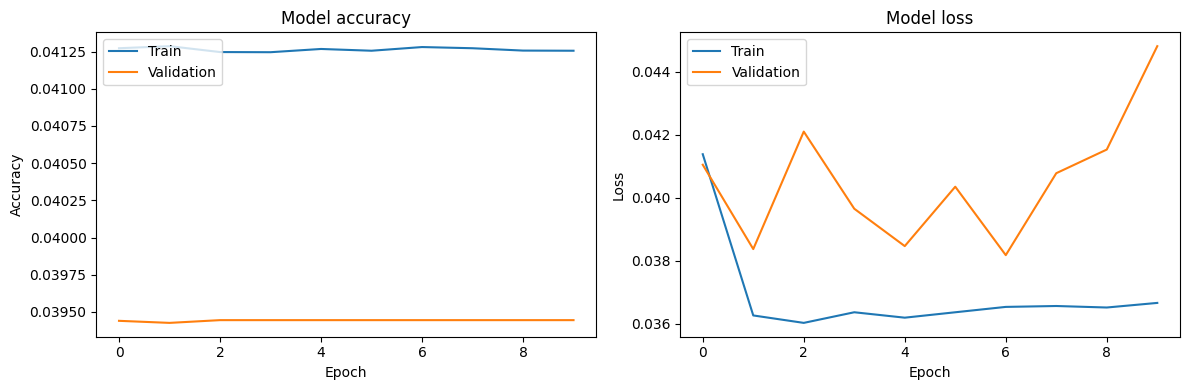

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [31]:
model.save('TrainedModel.h5')

c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


938/938 [==============================] - 5s 5ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


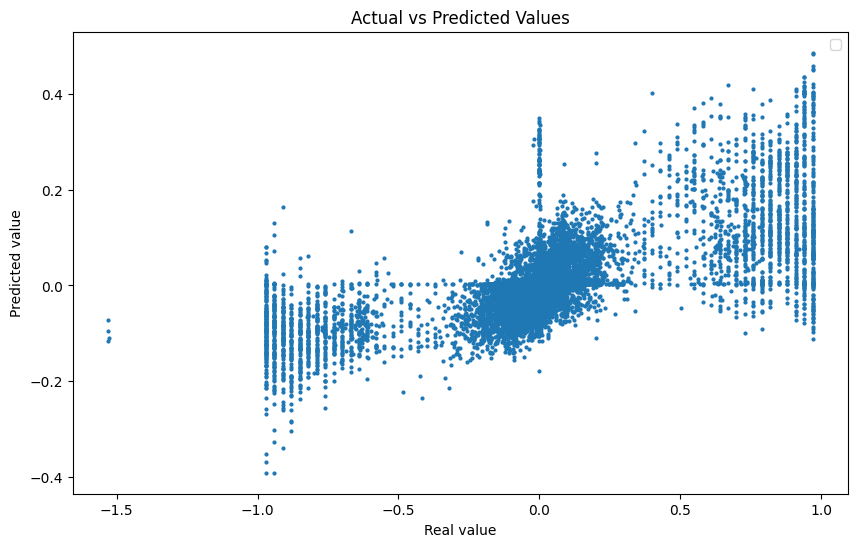

Predicted rating: [0.00201367], True rating: -0.0011
Predicted rating: [0.00201367], True rating: 0.0017000000000000001
Predicted rating: [0.00201367], True rating: -0.0021
Predicted rating: [0.00201367], True rating: 0.0038
Predicted rating: [0.00201367], True rating: 0.0025
Predicted rating: [0.00201367], True rating: 0.0064
Predicted rating: [0.00201367], True rating: 0.0018
Predicted rating: [0.00201367], True rating: 0.0026
Predicted rating: [0.00201367], True rating: 0.001
Predicted rating: [0.00219535], True rating: 0.0018
Predicted rating: [0.00224147], True rating: -0.011000000000000001
Predicted rating: [0.00207838], True rating: -0.0087
Predicted rating: [0.00223043], True rating: -0.0084
Predicted rating: [0.00248287], True rating: 0.0045000000000000005
Predicted rating: [0.00223067], True rating: 0.0037
Predicted rating: [0.00183365], True rating: 0.015300000000000001
Predicted rating: [0.00227964], True rating: -0.0369
Predicted rating: [0.00850735], True rating: -0.0325


In [39]:
import matplotlib.pyplot as plt

# Predict the ratings for the test data
y_pred = model.predict(x_test[:30000])

plt.figure(figsize=(10, 6))

plt.plot(y_test[:30000], y_pred, marker='o', linestyle='None', markersize=2)

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()


# Print the predicted and true ratings for the test data
for i in range(min(len(x_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")


In [33]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
